In [1]:
!pip install openpyxl



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


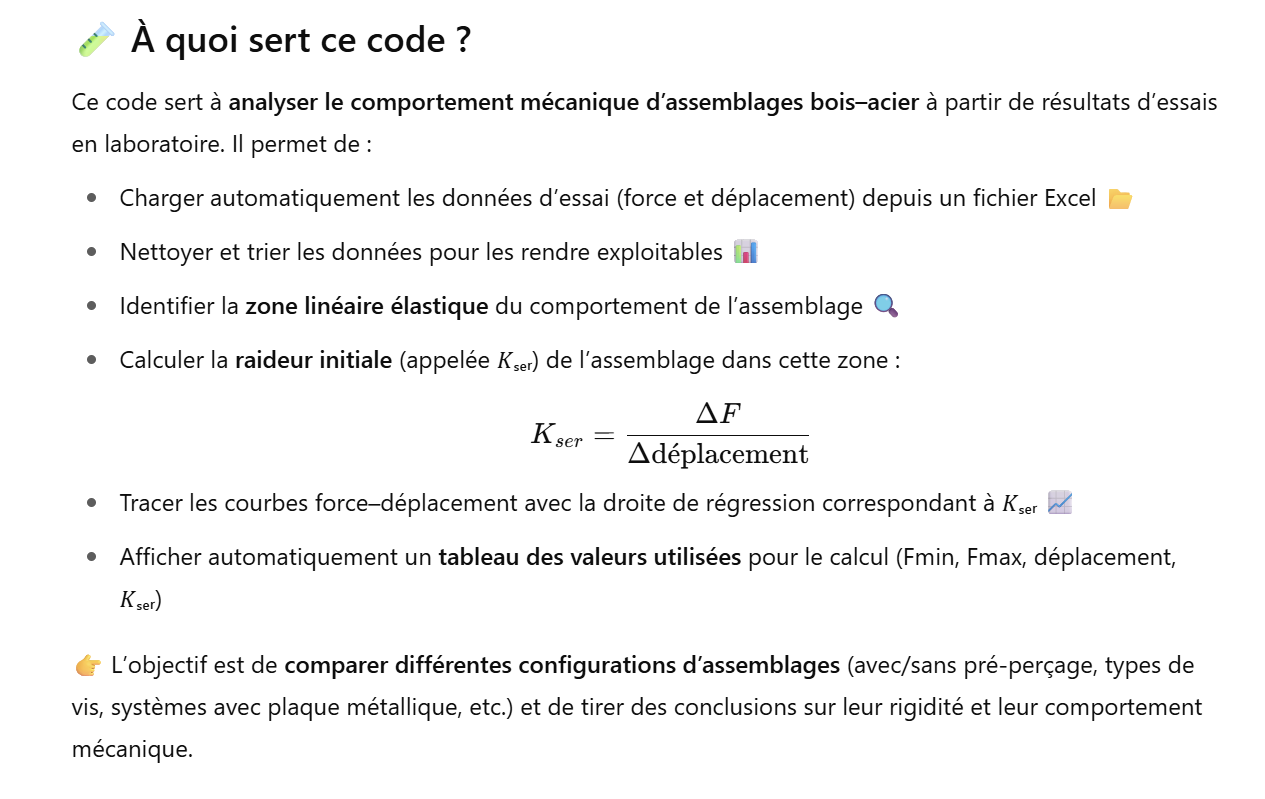

# Assamblage percé et non prépercé 

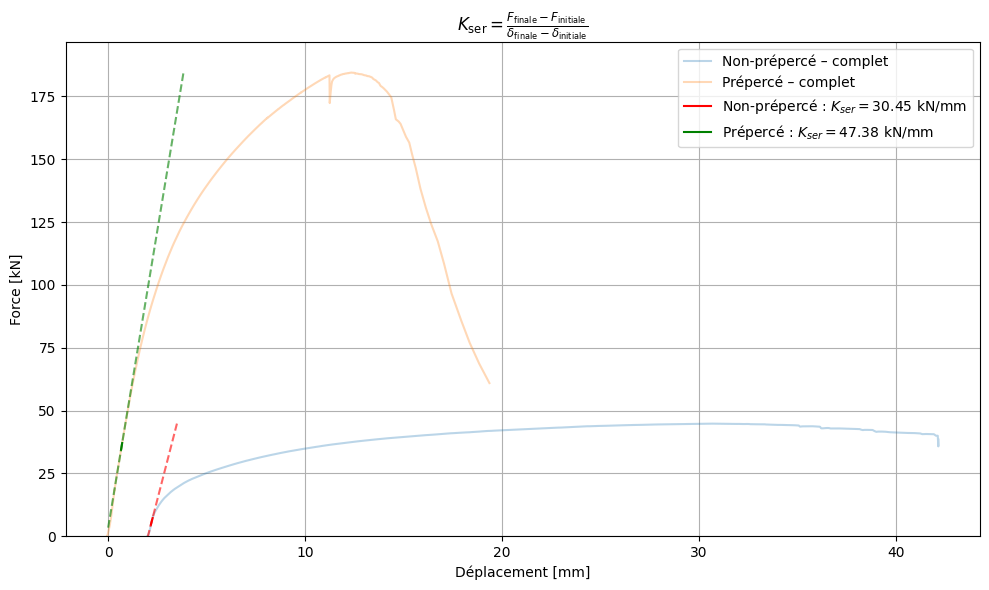

,Essai,Déplacement initial [mm],Force initiale [kN],Déplacement finale [mm],Force finale [kN],Kser (extrémités) [kN/mm],R² zone linéaire
0,Non-prépercé,2.169658,4.5964,2.256452,7.2396,30.453661,0.999756
1,Prépercé,0.654977,34.4224,0.711436,37.0972,47.376030,0.999956


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython.display import display

# === Chargement des données
df_non_prep = pd.read_excel("ASS_BOIS_non-prépercé.xlsx", sheet_name="Series_1")
df_prep = pd.read_excel("ASS_BOIS_prépercé.xlsx", sheet_name="Series_1")

# === Nettoyage
def nettoyer(df):
    df = df.copy()
    df['Force [kN]'] = df['Force [ N ]'].abs() / 1000
    df['Déplacement [mm]'] = df['Déplacement [ mm ]']
    df = df.sort_values(by='Déplacement [mm]').reset_index(drop=True)
    return df

df_non_prep = nettoyer(df_non_prep)
df_prep = nettoyer(df_prep)

# === Paramètres
F_min_np = 1 #kN
F_max_np = 10 #kN
taille_fenetre_np = 100

F_min_p = 30 #kN
F_max_p = 70 #kN
taille_fenetre_p = 100

# === Recherche zone linéaire
def trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre_init=100):
    df_zone = df[(df['Force [kN]'] >= F_min) & (df['Force [kN]'] <= F_max)].reset_index(drop=True)
    max_points = len(df_zone)
    if max_points < 2:
        return None, None, None, df_zone

    taille_fenetre = min(taille_fenetre_init, max_points - 1)
    best_r2, best_coef, intercept, best_start = 0, 0, 0, 0

    for start in range(0, max_points - taille_fenetre):
        end = start + taille_fenetre
        X = df_zone.loc[start:end, ['Déplacement [mm]']].values
        y = df_zone.loc[start:end, 'Force [kN]'].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        if r2 > best_r2:
            best_r2 = r2
            best_coef = model.coef_[0]
            intercept = model.intercept_
            best_start = start

    zone_df = df_zone.loc[best_start:best_start + taille_fenetre].reset_index(drop=True)
    return best_coef, intercept, best_r2, zone_df

# === Application aux deux séries
a_np, b_np, r2_np, zone_np_best = trouver_kser_zone_lineaire_dans_force(df_non_prep, F_min_np, F_max_np, taille_fenetre_np)
a_p, b_p, r2_p, zone_p_best = trouver_kser_zone_lineaire_dans_force(df_prep, F_min_p, F_max_p, taille_fenetre_p)

# === Kser entre extrémités (selon formule image)
def kser_depuis_extremites(zone_df):
    F1 = zone_df['Force [kN]'].iloc[0]
    F2 = zone_df['Force [kN]'].iloc[-1]
    d1 = zone_df['Déplacement [mm]'].iloc[0]
    d2 = zone_df['Déplacement [mm]'].iloc[-1]
    return (F2 - F1) / (d2 - d1)

Kser_np_ext = kser_depuis_extremites(zone_np_best)
Kser_p_ext = kser_depuis_extremites(zone_p_best)

# === Prolonger droite
def prolonger_droite_de_0_a_Fmax(a, b, F_max):
    x_vals = np.linspace(0, (F_max - b) / a, 500)
    y_vals = a * x_vals + b
    return x_vals[y_vals <= F_max], y_vals[y_vals <= F_max]

x_ext_np, y_ext_np = prolonger_droite_de_0_a_Fmax(a_np, b_np, df_non_prep['Force [kN]'].max())
x_ext_p, y_ext_p = prolonger_droite_de_0_a_Fmax(a_p, b_p, df_prep['Force [kN]'].max())

# === Affichage du graphique avec Kser (extrémités) dans la légende
plt.figure(figsize=(10, 6))
plt.plot(df_non_prep['Déplacement [mm]'], df_non_prep['Force [kN]'], alpha=0.3, label="Non-prépercé – complet")
plt.plot(df_prep['Déplacement [mm]'], df_prep['Force [kN]'], alpha=0.3, label="Prépercé – complet")

plt.plot(zone_np_best['Déplacement [mm]'], zone_np_best['Force [kN]'], color='red',
         label=f"Non-prépercé : $K_{{ser}} = {Kser_np_ext:.2f}$ kN/mm")
plt.plot(zone_p_best['Déplacement [mm]'], zone_p_best['Force [kN]'], color='green',
         label=f"Prépercé : $K_{{ser}} = {Kser_p_ext:.2f}$ kN/mm")

plt.plot(x_ext_np, y_ext_np, '--', color='red', alpha=0.6)
plt.plot(x_ext_p, y_ext_p, '--', color='green', alpha=0.6)

plt.xlabel("Déplacement [mm]")
plt.ylabel("Force [kN]")
plt.ylim(bottom=0)
plt.title(r"$K_{\mathrm{ser}} = \frac{F_{\mathrm{finale}} - F_{\mathrm{initiale}}}{\delta_{\mathrm{finale}} - \delta_{\mathrm{initiale}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Tableau avec valeurs extraites et Kser calculé selon la formule
tableau_final = pd.DataFrame({
    "Essai": ["Non-prépercé", "Prépercé"],
    "Déplacement initial [mm]": [zone_np_best['Déplacement [mm]'].iloc[0], zone_p_best['Déplacement [mm]'].iloc[0]],
    "Force initiale [kN]": [zone_np_best['Force [kN]'].iloc[0], zone_p_best['Force [kN]'].iloc[0]],
    "Déplacement finale [mm]": [zone_np_best['Déplacement [mm]'].iloc[-1], zone_p_best['Déplacement [mm]'].iloc[-1]],
    "Force finale [kN]": [zone_np_best['Force [kN]'].iloc[-1], zone_p_best['Force [kN]'].iloc[-1]],
    "Kser (extrémités) [kN/mm]": [Kser_np_ext, Kser_p_ext],
    "R² zone linéaire": [r2_np, r2_p]
})

display(tableau_final)



# B1-1

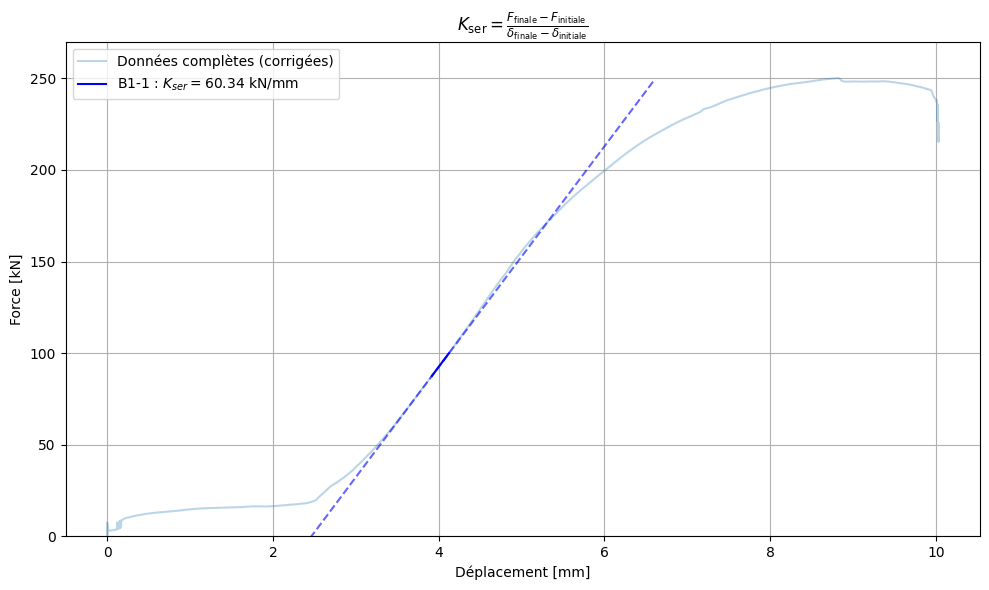

,Essai,Déplacement initial [mm],Force initiale [kN],Déplacement finale [mm],Force finale [kN],Kser (extrémités) [kN/mm],R² zone linéaire
0,B1-1,3.917,87.48,4.123,99.91,60.339806,0.999965


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Chargement des données
file_path = "Essais assemblage plaque acier.xlsx"  # Mets le chemin si besoin
sheet_name = "B1-1"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# === Nettoyage et inversion des déplacements
df.columns = ["Force [kN]", "Déplacement [mm]"]
df["Déplacement [mm]"] = -df["Déplacement [mm]"]  # inversion du signe
df = df.sort_values(by="Déplacement [mm]").reset_index(drop=True)

# === Paramètres d’analyse
F_min = 50  # kN
F_max = 150 # kN
taille_fenetre = 50

# === Recherche zone linéaire
def trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre_init=100):
    df_zone = df[(df['Force [kN]'] >= F_min) & (df['Force [kN]'] <= F_max)].reset_index(drop=True)
    max_points = len(df_zone)
    if max_points < 2:
        return None, None, None, df_zone

    taille_fenetre = min(taille_fenetre_init, max_points - 1)
    best_r2, best_coef, intercept, best_start = 0, 0, 0, 0

    for start in range(0, max_points - taille_fenetre):
        end = start + taille_fenetre
        X = df_zone.loc[start:end, ['Déplacement [mm]']].values
        y = df_zone.loc[start:end, 'Force [kN]'].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        if r2 > best_r2:
            best_r2 = r2
            best_coef = model.coef_[0]
            intercept = model.intercept_
            best_start = start

    zone_df = df_zone.loc[best_start:best_start + taille_fenetre].reset_index(drop=True)
    return best_coef, intercept, best_r2, zone_df

# === Application
a, b, r2, zone_best = trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre)

# === Kser entre extrémités
def kser_depuis_extremites(zone_df):
    F1 = zone_df['Force [kN]'].iloc[0]
    F2 = zone_df['Force [kN]'].iloc[-1]
    d1 = zone_df['Déplacement [mm]'].iloc[0]
    d2 = zone_df['Déplacement [mm]'].iloc[-1]
    return (F2 - F1) / (d2 - d1)

Kser_ext = kser_depuis_extremites(zone_best)

# === Prolongement de droite
def prolonger_droite_de_0_a_Fmax(a, b, F_max):
    x_vals = np.linspace(0, (F_max - b) / a, 500)
    y_vals = a * x_vals + b
    return x_vals[y_vals <= F_max], y_vals[y_vals <= F_max]

x_ext, y_ext = prolonger_droite_de_0_a_Fmax(a, b, df['Force [kN]'].max())

# === Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(df['Déplacement [mm]'], df['Force [kN]'], alpha=0.3, label="Données complètes (corrigées)")
plt.plot(zone_best['Déplacement [mm]'], zone_best['Force [kN]'], color='blue',
         label=f"B1-1 : $K_{{ser}} = {Kser_ext:.2f}$ kN/mm")
plt.plot(x_ext, y_ext, '--', color='blue', alpha=0.6)
plt.xlabel("Déplacement [mm]")
plt.ylabel("Force [kN]")
plt.ylim(bottom=0)
plt.title(r"$K_{\mathrm{ser}} = \frac{F_{\mathrm{finale}} - F_{\mathrm{initiale}}}{\delta_{\mathrm{finale}} - \delta_{\mathrm{initiale}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Tableau récapitulatif
tableau_final = pd.DataFrame({
    "Essai": ["B1-1"],
    "Déplacement initial [mm]": [zone_best['Déplacement [mm]'].iloc[0]],
    "Force initiale [kN]": [zone_best['Force [kN]'].iloc[0]],
    "Déplacement finale [mm]": [zone_best['Déplacement [mm]'].iloc[-1]],
    "Force finale [kN]": [zone_best['Force [kN]'].iloc[-1]],
    "Kser (extrémités) [kN/mm]": [Kser_ext],
    "R² zone linéaire": [r2]
})

# === Affichage du tableau dans la console Jupyter
display(tableau_final)


# B1-2

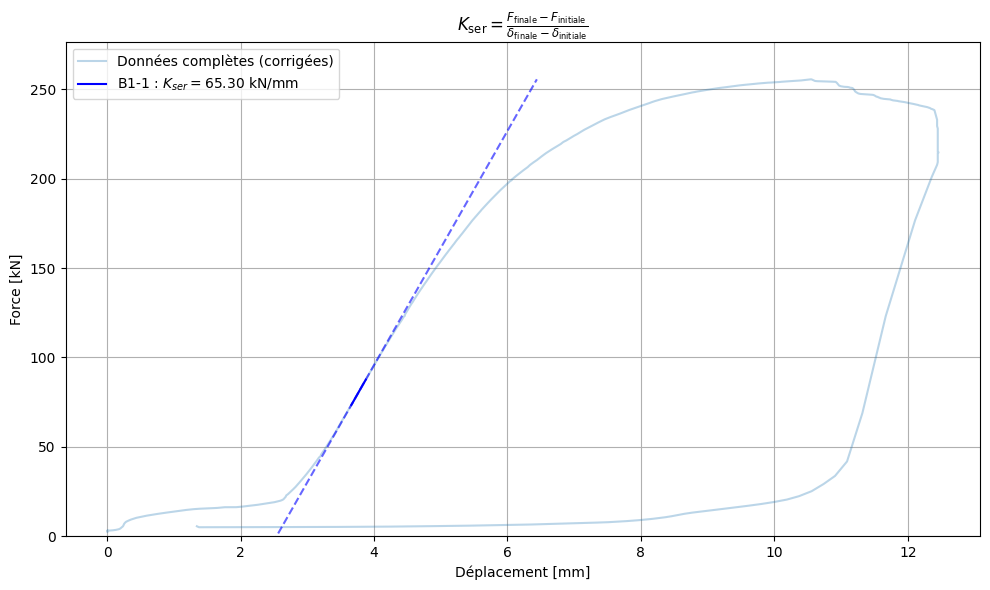

,Essai,Déplacement initial [mm],Force initiale [kN],Déplacement finale [mm],Force finale [kN],Kser (extrémités) [kN/mm],R² zone linéaire
0,B1-1,3.659,73.41,3.876,87.58,65.299539,0.999972


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Chargement des données
file_path = "Essais assemblage plaque acier.xlsx"  # Mets le chemin si besoin
sheet_name = "B1-2"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# === Nettoyage et inversion des déplacements
df.columns = ["Force [kN]", "Déplacement [mm]"]
df["Déplacement [mm]"] = -df["Déplacement [mm]"]  # inversion du signe
df = df.reset_index(drop=True)  # garde l'ordre brut sans tri


# === Paramètres d’analyse
F_min = 50  # kN
F_max = 150 # kN
taille_fenetre = 50

# === Recherche zone linéaire
def trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre_init=100):
    df_zone = df[(df['Force [kN]'] >= F_min) & (df['Force [kN]'] <= F_max)].reset_index(drop=True)
    max_points = len(df_zone)
    if max_points < 2:
        return None, None, None, df_zone

    taille_fenetre = min(taille_fenetre_init, max_points - 1)
    best_r2, best_coef, intercept, best_start = 0, 0, 0, 0

    for start in range(0, max_points - taille_fenetre):
        end = start + taille_fenetre
        X = df_zone.loc[start:end, ['Déplacement [mm]']].values
        y = df_zone.loc[start:end, 'Force [kN]'].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        if r2 > best_r2:
            best_r2 = r2
            best_coef = model.coef_[0]
            intercept = model.intercept_
            best_start = start

    zone_df = df_zone.loc[best_start:best_start + taille_fenetre].reset_index(drop=True)
    return best_coef, intercept, best_r2, zone_df

# === Application
a, b, r2, zone_best = trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre)

# === Kser entre extrémités
def kser_depuis_extremites(zone_df):
    F1 = zone_df['Force [kN]'].iloc[0]
    F2 = zone_df['Force [kN]'].iloc[-1]
    d1 = zone_df['Déplacement [mm]'].iloc[0]
    d2 = zone_df['Déplacement [mm]'].iloc[-1]
    return (F2 - F1) / (d2 - d1)

Kser_ext = kser_depuis_extremites(zone_best)

# === Prolongement de droite
def prolonger_droite_de_0_a_Fmax(a, b, F_max):
    x_vals = np.linspace(0, (F_max - b) / a, 500)
    y_vals = a * x_vals + b
    return x_vals[y_vals <= F_max], y_vals[y_vals <= F_max]

x_ext, y_ext = prolonger_droite_de_0_a_Fmax(a, b, df['Force [kN]'].max())

# === Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(df['Déplacement [mm]'], df['Force [kN]'], alpha=0.3, label="Données complètes (corrigées)")
plt.plot(zone_best['Déplacement [mm]'], zone_best['Force [kN]'], color='blue',
         label=f"B1-1 : $K_{{ser}} = {Kser_ext:.2f}$ kN/mm")
plt.plot(x_ext, y_ext, '--', color='blue', alpha=0.6)
plt.xlabel("Déplacement [mm]")
plt.ylabel("Force [kN]")
plt.ylim(bottom=0)
plt.title(r"$K_{\mathrm{ser}} = \frac{F_{\mathrm{finale}} - F_{\mathrm{initiale}}}{\delta_{\mathrm{finale}} - \delta_{\mathrm{initiale}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Tableau récapitulatif
tableau_final = pd.DataFrame({
    "Essai": ["B1-1"],
    "Déplacement initial [mm]": [zone_best['Déplacement [mm]'].iloc[0]],
    "Force initiale [kN]": [zone_best['Force [kN]'].iloc[0]],
    "Déplacement finale [mm]": [zone_best['Déplacement [mm]'].iloc[-1]],
    "Force finale [kN]": [zone_best['Force [kN]'].iloc[-1]],
    "Kser (extrémités) [kN/mm]": [Kser_ext],
    "R² zone linéaire": [r2]
})

# === Affichage du tableau dans la console Jupyter
display(tableau_final)


# B1-3

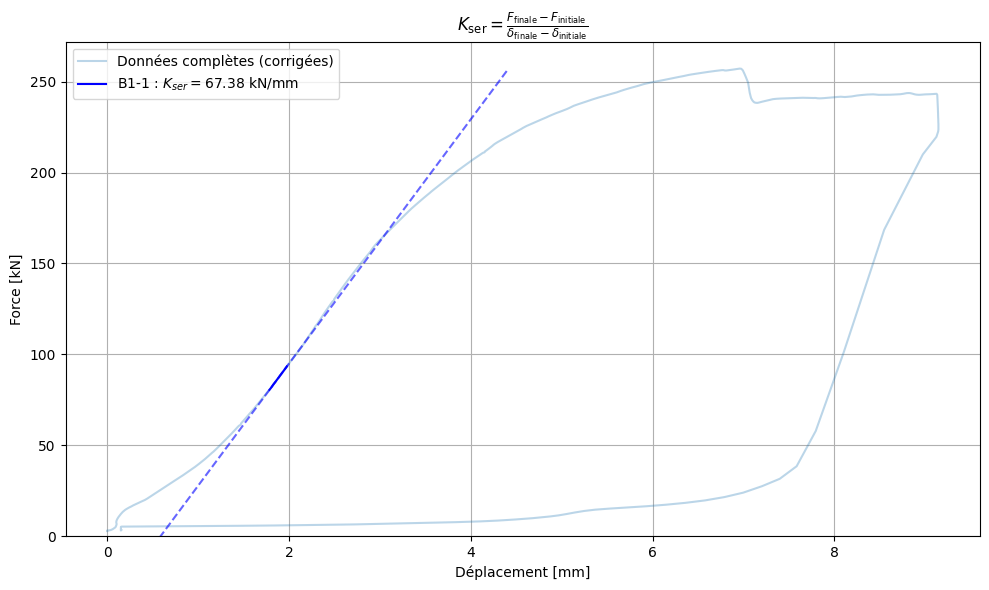

,Essai,Déplacement initial [mm],Force initiale [kN],Déplacement finale [mm],Force finale [kN],Kser (extrémités) [kN/mm],R² zone linéaire
0,B1-1,1.785,80.53,1.976,93.4,67.382199,0.999945


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Chargement des données
file_path = "Essais assemblage plaque acier.xlsx"  # Mets le chemin si besoin
sheet_name = "B1-3"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# === Nettoyage et inversion des déplacements
df.columns = ["Force [kN]", "Déplacement [mm]"]
df["Déplacement [mm]"] = -df["Déplacement [mm]"]  # inversion du signe
df = df.reset_index(drop=True)  # garde l'ordre brut sans tri


# === Paramètres d’analyse
F_min = 50  # kN
F_max = 150 # kN
taille_fenetre = 50

# === Recherche zone linéaire
def trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre_init=100):
    df_zone = df[(df['Force [kN]'] >= F_min) & (df['Force [kN]'] <= F_max)].reset_index(drop=True)
    max_points = len(df_zone)
    if max_points < 2:
        return None, None, None, df_zone

    taille_fenetre = min(taille_fenetre_init, max_points - 1)
    best_r2, best_coef, intercept, best_start = 0, 0, 0, 0

    for start in range(0, max_points - taille_fenetre):
        end = start + taille_fenetre
        X = df_zone.loc[start:end, ['Déplacement [mm]']].values
        y = df_zone.loc[start:end, 'Force [kN]'].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        if r2 > best_r2:
            best_r2 = r2
            best_coef = model.coef_[0]
            intercept = model.intercept_
            best_start = start

    zone_df = df_zone.loc[best_start:best_start + taille_fenetre].reset_index(drop=True)
    return best_coef, intercept, best_r2, zone_df

# === Application
a, b, r2, zone_best = trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre)

# === Kser entre extrémités
def kser_depuis_extremites(zone_df):
    F1 = zone_df['Force [kN]'].iloc[0]
    F2 = zone_df['Force [kN]'].iloc[-1]
    d1 = zone_df['Déplacement [mm]'].iloc[0]
    d2 = zone_df['Déplacement [mm]'].iloc[-1]
    return (F2 - F1) / (d2 - d1)

Kser_ext = kser_depuis_extremites(zone_best)

# === Prolongement de droite
def prolonger_droite_de_0_a_Fmax(a, b, F_max):
    x_vals = np.linspace(0, (F_max - b) / a, 500)
    y_vals = a * x_vals + b
    return x_vals[y_vals <= F_max], y_vals[y_vals <= F_max]

x_ext, y_ext = prolonger_droite_de_0_a_Fmax(a, b, df['Force [kN]'].max())

# === Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(df['Déplacement [mm]'], df['Force [kN]'], alpha=0.3, label="Données complètes (corrigées)")
plt.plot(zone_best['Déplacement [mm]'], zone_best['Force [kN]'], color='blue',
         label=f"B1-1 : $K_{{ser}} = {Kser_ext:.2f}$ kN/mm")
plt.plot(x_ext, y_ext, '--', color='blue', alpha=0.6)
plt.xlabel("Déplacement [mm]")
plt.ylabel("Force [kN]")
plt.ylim(bottom=0)
plt.title(r"$K_{\mathrm{ser}} = \frac{F_{\mathrm{finale}} - F_{\mathrm{initiale}}}{\delta_{\mathrm{finale}} - \delta_{\mathrm{initiale}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Tableau récapitulatif
tableau_final = pd.DataFrame({
    "Essai": ["B1-1"],
    "Déplacement initial [mm]": [zone_best['Déplacement [mm]'].iloc[0]],
    "Force initiale [kN]": [zone_best['Force [kN]'].iloc[0]],
    "Déplacement finale [mm]": [zone_best['Déplacement [mm]'].iloc[-1]],
    "Force finale [kN]": [zone_best['Force [kN]'].iloc[-1]],
    "Kser (extrémités) [kN/mm]": [Kser_ext],
    "R² zone linéaire": [r2]
})

# === Affichage du tableau dans la console Jupyter
display(tableau_final)


# T1-1

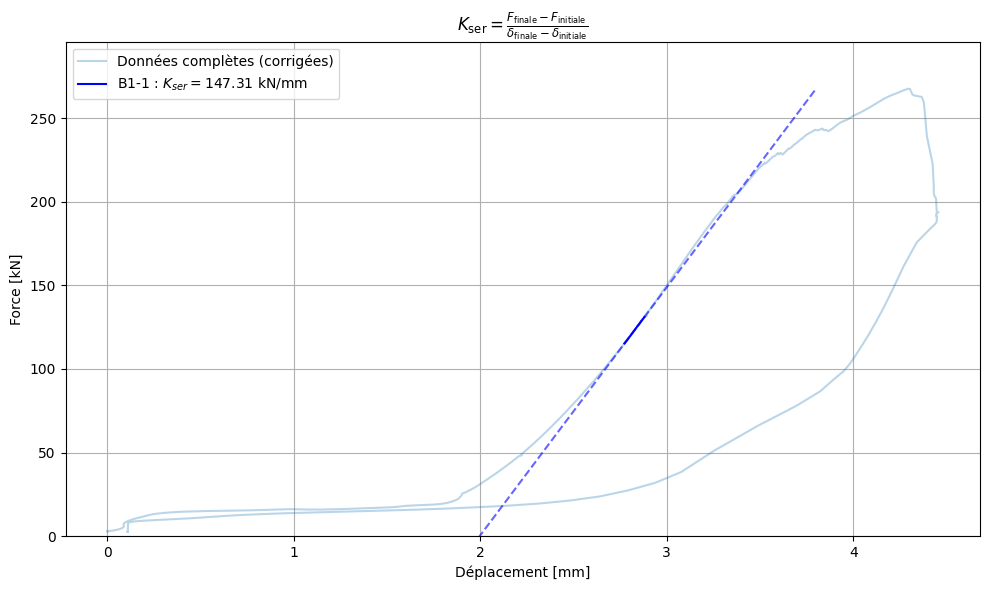

,Essai,Déplacement initial [mm],Force initiale [kN],Déplacement finale [mm],Force finale [kN],Kser (extrémités) [kN/mm],R² zone linéaire
0,B1-1,2.773,115.25,2.881,131.16,147.314815,0.999882


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Chargement des données
file_path = "Essais assemblage plaque acier.xlsx"  # Mets le chemin si besoin
sheet_name = "T1-1"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# === Nettoyage et inversion des déplacements
df.columns = ["Force [kN]", "Déplacement [mm]"]
df["Déplacement [mm]"] = -df["Déplacement [mm]"]  # inversion du signe
df = df.reset_index(drop=True)  # garde l'ordre brut sans tri


# === Paramètres d’analyse
F_min = 50  # kN
F_max = 150 # kN
taille_fenetre = 50

# === Recherche zone linéaire
def trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre_init=100):
    df_zone = df[(df['Force [kN]'] >= F_min) & (df['Force [kN]'] <= F_max)].reset_index(drop=True)
    max_points = len(df_zone)
    if max_points < 2:
        return None, None, None, df_zone

    taille_fenetre = min(taille_fenetre_init, max_points - 1)
    best_r2, best_coef, intercept, best_start = 0, 0, 0, 0

    for start in range(0, max_points - taille_fenetre):
        end = start + taille_fenetre
        X = df_zone.loc[start:end, ['Déplacement [mm]']].values
        y = df_zone.loc[start:end, 'Force [kN]'].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        if r2 > best_r2:
            best_r2 = r2
            best_coef = model.coef_[0]
            intercept = model.intercept_
            best_start = start

    zone_df = df_zone.loc[best_start:best_start + taille_fenetre].reset_index(drop=True)
    return best_coef, intercept, best_r2, zone_df

# === Application
a, b, r2, zone_best = trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre)

# === Kser entre extrémités
def kser_depuis_extremites(zone_df):
    F1 = zone_df['Force [kN]'].iloc[0]
    F2 = zone_df['Force [kN]'].iloc[-1]
    d1 = zone_df['Déplacement [mm]'].iloc[0]
    d2 = zone_df['Déplacement [mm]'].iloc[-1]
    return (F2 - F1) / (d2 - d1)

Kser_ext = kser_depuis_extremites(zone_best)

# === Prolongement de droite
def prolonger_droite_de_0_a_Fmax(a, b, F_max):
    x_vals = np.linspace(0, (F_max - b) / a, 500)
    y_vals = a * x_vals + b
    return x_vals[y_vals <= F_max], y_vals[y_vals <= F_max]

x_ext, y_ext = prolonger_droite_de_0_a_Fmax(a, b, df['Force [kN]'].max())

# === Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(df['Déplacement [mm]'], df['Force [kN]'], alpha=0.3, label="Données complètes (corrigées)")
plt.plot(zone_best['Déplacement [mm]'], zone_best['Force [kN]'], color='blue',
         label=f"B1-1 : $K_{{ser}} = {Kser_ext:.2f}$ kN/mm")
plt.plot(x_ext, y_ext, '--', color='blue', alpha=0.6)
plt.xlabel("Déplacement [mm]")
plt.ylabel("Force [kN]")
plt.ylim(bottom=0)
plt.title(r"$K_{\mathrm{ser}} = \frac{F_{\mathrm{finale}} - F_{\mathrm{initiale}}}{\delta_{\mathrm{finale}} - \delta_{\mathrm{initiale}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Tableau récapitulatif
tableau_final = pd.DataFrame({
    "Essai": ["B1-1"],
    "Déplacement initial [mm]": [zone_best['Déplacement [mm]'].iloc[0]],
    "Force initiale [kN]": [zone_best['Force [kN]'].iloc[0]],
    "Déplacement finale [mm]": [zone_best['Déplacement [mm]'].iloc[-1]],
    "Force finale [kN]": [zone_best['Force [kN]'].iloc[-1]],
    "Kser (extrémités) [kN/mm]": [Kser_ext],
    "R² zone linéaire": [r2]
})

# === Affichage du tableau dans la console Jupyter
display(tableau_final)


# T1-2

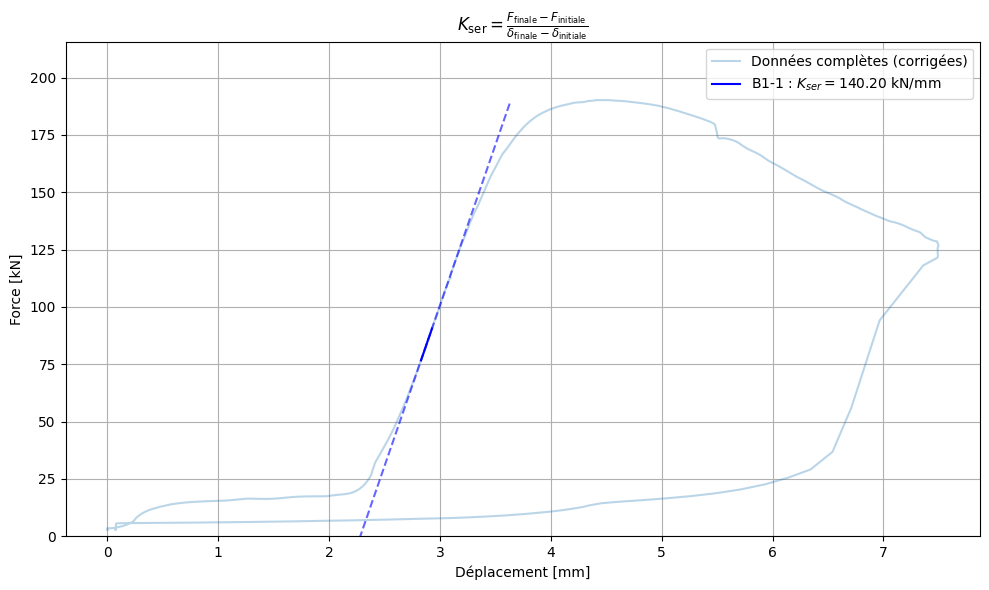

,Essai,Déplacement initial [mm],Force initiale [kN],Déplacement finale [mm],Force finale [kN],Kser (extrémités) [kN/mm],R² zone linéaire
0,B1-1,2.83,76.71,2.929,90.59,140.20202,0.99995


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Chargement des données
file_path = "Essais assemblage plaque acier.xlsx"  # Mets le chemin si besoin
sheet_name = "T1-2"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# === Nettoyage et inversion des déplacements
df.columns = ["Force [kN]", "Déplacement [mm]"]
df["Déplacement [mm]"] = -df["Déplacement [mm]"]  # inversion du signe
df = df.reset_index(drop=True)  # garde l'ordre brut sans tri


# === Paramètres d’analyse
F_min = 50  # kN
F_max = 150 # kN
taille_fenetre = 50

# === Recherche zone linéaire
def trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre_init=100):
    df_zone = df[(df['Force [kN]'] >= F_min) & (df['Force [kN]'] <= F_max)].reset_index(drop=True)
    max_points = len(df_zone)
    if max_points < 2:
        return None, None, None, df_zone

    taille_fenetre = min(taille_fenetre_init, max_points - 1)
    best_r2, best_coef, intercept, best_start = 0, 0, 0, 0

    for start in range(0, max_points - taille_fenetre):
        end = start + taille_fenetre
        X = df_zone.loc[start:end, ['Déplacement [mm]']].values
        y = df_zone.loc[start:end, 'Force [kN]'].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        if r2 > best_r2:
            best_r2 = r2
            best_coef = model.coef_[0]
            intercept = model.intercept_
            best_start = start

    zone_df = df_zone.loc[best_start:best_start + taille_fenetre].reset_index(drop=True)
    return best_coef, intercept, best_r2, zone_df

# === Application
a, b, r2, zone_best = trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre)

# === Kser entre extrémités
def kser_depuis_extremites(zone_df):
    F1 = zone_df['Force [kN]'].iloc[0]
    F2 = zone_df['Force [kN]'].iloc[-1]
    d1 = zone_df['Déplacement [mm]'].iloc[0]
    d2 = zone_df['Déplacement [mm]'].iloc[-1]
    return (F2 - F1) / (d2 - d1)

Kser_ext = kser_depuis_extremites(zone_best)

# === Prolongement de droite
def prolonger_droite_de_0_a_Fmax(a, b, F_max):
    x_vals = np.linspace(0, (F_max - b) / a, 500)
    y_vals = a * x_vals + b
    return x_vals[y_vals <= F_max], y_vals[y_vals <= F_max]

x_ext, y_ext = prolonger_droite_de_0_a_Fmax(a, b, df['Force [kN]'].max())

# === Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(df['Déplacement [mm]'], df['Force [kN]'], alpha=0.3, label="Données complètes (corrigées)")
plt.plot(zone_best['Déplacement [mm]'], zone_best['Force [kN]'], color='blue',
         label=f"B1-1 : $K_{{ser}} = {Kser_ext:.2f}$ kN/mm")
plt.plot(x_ext, y_ext, '--', color='blue', alpha=0.6)
plt.xlabel("Déplacement [mm]")
plt.ylabel("Force [kN]")
plt.ylim(bottom=0)
plt.title(r"$K_{\mathrm{ser}} = \frac{F_{\mathrm{finale}} - F_{\mathrm{initiale}}}{\delta_{\mathrm{finale}} - \delta_{\mathrm{initiale}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Tableau récapitulatif
tableau_final = pd.DataFrame({
    "Essai": ["B1-1"],
    "Déplacement initial [mm]": [zone_best['Déplacement [mm]'].iloc[0]],
    "Force initiale [kN]": [zone_best['Force [kN]'].iloc[0]],
    "Déplacement finale [mm]": [zone_best['Déplacement [mm]'].iloc[-1]],
    "Force finale [kN]": [zone_best['Force [kN]'].iloc[-1]],
    "Kser (extrémités) [kN/mm]": [Kser_ext],
    "R² zone linéaire": [r2]
})

# === Affichage du tableau dans la console Jupyter
display(tableau_final)


# T1-3

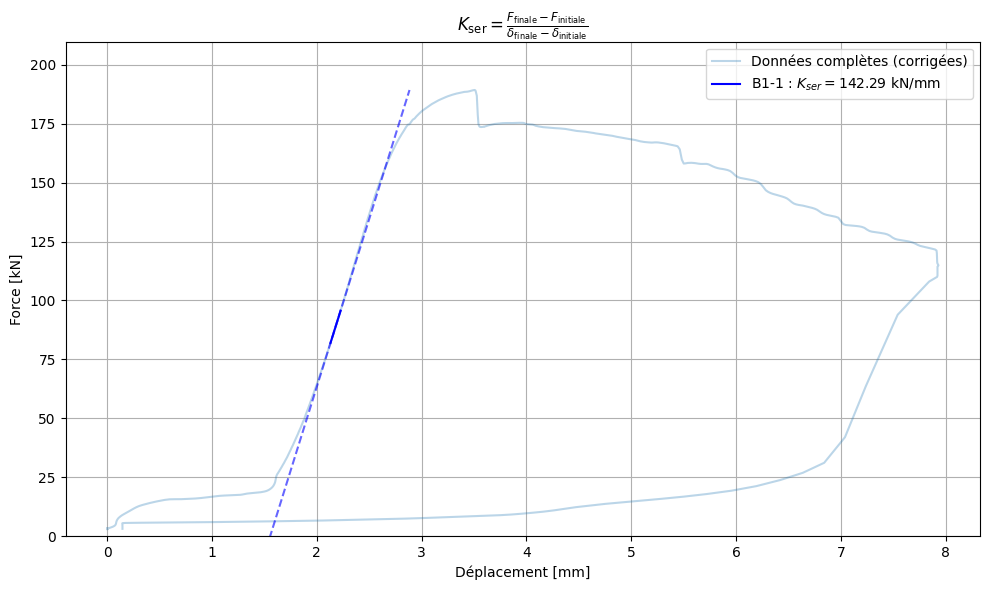

,Essai,Déplacement initial [mm],Force initiale [kN],Déplacement finale [mm],Force finale [kN],Kser (extrémités) [kN/mm],R² zone linéaire
0,B1-1,2.13,81.96,2.226,95.62,142.291667,0.999907


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Chargement des données
file_path = "Essais assemblage plaque acier.xlsx"  # Mets le chemin si besoin
sheet_name = "T1-3"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# === Nettoyage et inversion des déplacements
df.columns = ["Force [kN]", "Déplacement [mm]"]
df["Déplacement [mm]"] = -df["Déplacement [mm]"]  # inversion du signe
df = df.reset_index(drop=True)  # garde l'ordre brut sans tri


# === Paramètres d’analyse
F_min = 50  # kN
F_max = 150 # kN
taille_fenetre = 50

# === Recherche zone linéaire
def trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre_init=100):
    df_zone = df[(df['Force [kN]'] >= F_min) & (df['Force [kN]'] <= F_max)].reset_index(drop=True)
    max_points = len(df_zone)
    if max_points < 2:
        return None, None, None, df_zone

    taille_fenetre = min(taille_fenetre_init, max_points - 1)
    best_r2, best_coef, intercept, best_start = 0, 0, 0, 0

    for start in range(0, max_points - taille_fenetre):
        end = start + taille_fenetre
        X = df_zone.loc[start:end, ['Déplacement [mm]']].values
        y = df_zone.loc[start:end, 'Force [kN]'].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        if r2 > best_r2:
            best_r2 = r2
            best_coef = model.coef_[0]
            intercept = model.intercept_
            best_start = start

    zone_df = df_zone.loc[best_start:best_start + taille_fenetre].reset_index(drop=True)
    return best_coef, intercept, best_r2, zone_df

# === Application
a, b, r2, zone_best = trouver_kser_zone_lineaire_dans_force(df, F_min, F_max, taille_fenetre)

# === Kser entre extrémités
def kser_depuis_extremites(zone_df):
    F1 = zone_df['Force [kN]'].iloc[0]
    F2 = zone_df['Force [kN]'].iloc[-1]
    d1 = zone_df['Déplacement [mm]'].iloc[0]
    d2 = zone_df['Déplacement [mm]'].iloc[-1]
    return (F2 - F1) / (d2 - d1)

Kser_ext = kser_depuis_extremites(zone_best)

# === Prolongement de droite
def prolonger_droite_de_0_a_Fmax(a, b, F_max):
    x_vals = np.linspace(0, (F_max - b) / a, 500)
    y_vals = a * x_vals + b
    return x_vals[y_vals <= F_max], y_vals[y_vals <= F_max]

x_ext, y_ext = prolonger_droite_de_0_a_Fmax(a, b, df['Force [kN]'].max())

# === Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(df['Déplacement [mm]'], df['Force [kN]'], alpha=0.3, label="Données complètes (corrigées)")
plt.plot(zone_best['Déplacement [mm]'], zone_best['Force [kN]'], color='blue',
         label=f"B1-1 : $K_{{ser}} = {Kser_ext:.2f}$ kN/mm")
plt.plot(x_ext, y_ext, '--', color='blue', alpha=0.6)
plt.xlabel("Déplacement [mm]")
plt.ylabel("Force [kN]")
plt.ylim(bottom=0)
plt.title(r"$K_{\mathrm{ser}} = \frac{F_{\mathrm{finale}} - F_{\mathrm{initiale}}}{\delta_{\mathrm{finale}} - \delta_{\mathrm{initiale}}}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Tableau récapitulatif
tableau_final = pd.DataFrame({
    "Essai": ["B1-1"],
    "Déplacement initial [mm]": [zone_best['Déplacement [mm]'].iloc[0]],
    "Force initiale [kN]": [zone_best['Force [kN]'].iloc[0]],
    "Déplacement finale [mm]": [zone_best['Déplacement [mm]'].iloc[-1]],
    "Force finale [kN]": [zone_best['Force [kN]'].iloc[-1]],
    "Kser (extrémités) [kN/mm]": [Kser_ext],
    "R² zone linéaire": [r2]
})

# === Affichage du tableau dans la console Jupyter
display(tableau_final)
